In [42]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import cmocean
import cartopy.crs as ccrs

import warnings
warnings.filterwarnings('ignore')

# Summary
This notebooks opens the NOBM-OASIM dataset with PC scores and standardizes the env variables. It opens all the phyto .csv's that contain the MLR selected variables, coefficients, and intercept. It applies each MLR model to all phyto data > 0.01 and creates new scatterplots and maps.  

# Read in dataset w/ scores

In [254]:
rrs_xds = xr.open_dataset('/glusteruser/awindled/ALL_NOBM_OASIM_data_2020_w_EOF.nc', decode_times=False)
rrs_xds 

<xarray.Dataset>
Dimensions:         (months: 12, lat: 234, lon: 288, wavelength: 401)
Coordinates:
  * months          (months) float32 0.0 1.0 2.0 3.0 4.0 ... 8.0 9.0 10.0 11.0
  * lat             (lat) float32 -84.0 -83.33 -82.67 -82.0 ... 70.0 70.67 71.33
  * lon             (lon) float32 -180.0 -178.8 -177.5 ... 176.2 177.5 178.8
  * wavelength      (wavelength) int64 350 351 352 353 354 ... 747 748 749 750
    wv              (wavelength) int64 ...
Data variables: (12/57)
    tot             (months, lat, lon) float32 ...
    chl             (months, lat, lon) float32 ...
    dia             (months, lat, lon) float32 ...
    coc             (months, lat, lon) float32 ...
    cya             (months, lat, lon) float32 ...
    din             (months, lat, lon) float32 ...
    ...              ...
    EOF_3           (months, lat, lon) float64 ...
    EOF_4           (months, lat, lon) float64 ...
    EOF_5           (months, lat, lon) float64 ...
    EOF_6           (months, lat, lon) float64 ...
    EOF_7           (months, lat, lon) float64 ...
    EOF_8           (months, lat, lon) float64 ...

In [372]:
print(rrs_xds.cya.min(), rrs_xds.cya.max())

<xarray.DataArray 'cya' ()>
array(0.01000004) <xarray.DataArray 'cya' ()>
array(1.10306811)


# Standardize env variables (values range from 0-1)

In [255]:
env_vars = ['pic', 'irn', 'rno', 'h', 'sil', 'dtc', 'cdc', 't', 's', 'par']
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

for i in range(len(env_vars)):
    foo = rrs_xds[env_vars[i]].values.reshape(12*234*288)
    foo = scaler.fit_transform(foo.reshape(-1, 1))
    rrs_xds[env_vars[i]].values = foo.reshape(12,234,288)

# Make any phytoplankton value < 0.01 = 0

In [258]:
phyto_vars = ['tot', 'chl', 'dia', 'coc', 'cya', 'din', 'pha'] 

for i in range(len(phyto_vars)):
    rrs_xds[phyto_vars[i]] = rrs_xds[phyto_vars[i]].where(rrs_xds[phyto_vars[i]] > 0.01)
    

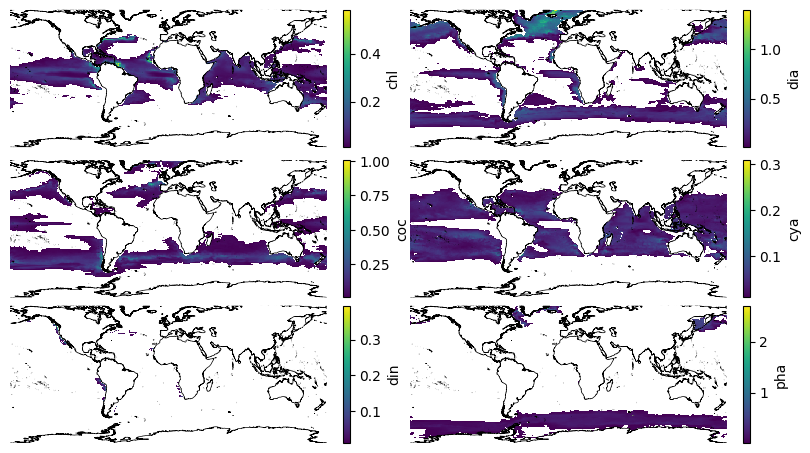

In [378]:
phyto_vars = ['chl', 'dia', 'coc', 'cya', 'din', 'pha'] 

myproj = ccrs.PlateCarree()
fig, axs = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True, 
                        figsize=(8,6), layout='compressed', subplot_kw={'projection': myproj})
axs = axs.ravel()

for i in range(len(phyto_vars)):
    im = rrs_xds[phyto_vars[i]][4,:,:].plot(ax=axs[i], 
                                            add_colorbar=False) # cmap=cmocean.cm.algae
    plt.colorbar(im, ax=axs[i], label= phyto_vars[i])

for ax in axs:
    ax.set_title("")
    ax.set(xlabel=None, ylabel=None)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.coastlines(resolution='10m', linewidth=0.5)

#fig.delaxes(axs[7])
#plt.savefig('/glusteruser/awindled/PCC_OASIM_figs/OASIM_phyto_filtered.png') 


In [260]:
from pylab import *
cmap = cm.get_cmap('Greys', 5)    

for i in range(cmap.N):
    rgba = cmap(i)
    # rgb2hex accepts rgb or rgba
    print(matplotlib.colors.rgb2hex(rgba))

#ffffff
#d9d9d9
#969696
#525252
#000000


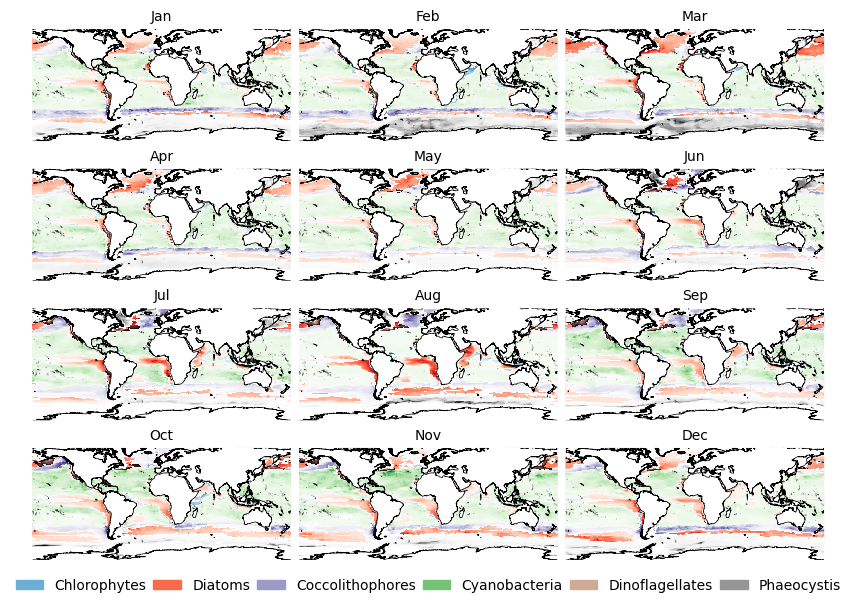

In [261]:
import matplotlib.patches as mpatches

fig, axs = plt.subplots(nrows=4, ncols=3, sharex=True, sharey=True, layout='compressed', figsize=(8,6),  subplot_kw={'projection': myproj})

axs = axs.ravel()

for i in range(0,12):
    rrs_xds[phyto_vars[1]][i,:,:].plot(ax=axs[i], add_colorbar=False, cmap='Blues', label='Chlorophytes') #chl
    rrs_xds[phyto_vars[2]][i,:,:].plot(ax=axs[i], add_colorbar=False, cmap='Reds', label='Diatoms') #dia
    rrs_xds[phyto_vars[3]][i,:,:].plot(ax=axs[i], add_colorbar=False, cmap='Purples', label='Coccolithophores') #coc
    rrs_xds[phyto_vars[4]][i,:,:].plot(ax=axs[i], add_colorbar=False, cmap='Greens', label='Cyanobacteria') #cya
    rrs_xds[phyto_vars[5]][i,:,:].plot(ax=axs[i], add_colorbar=False, cmap='pink', label='Dinoflagellates') #din
    rrs_xds[phyto_vars[6]][i,:,:].plot(ax=axs[i], add_colorbar=False, cmap='Greys', label='Phaeocystis') #pha

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
for i, ax in enumerate(axs.ravel()):
    ax.set_title(months[i], fontsize='10')
    ax.set(xlabel=None, ylabel=None)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.coastlines(resolution='10m', linewidth=0.5)

chl = mpatches.Patch(color='#6baed6', label='Chlorophytes')
dia = mpatches.Patch(color='#fb6a4a', label='Diatoms')
coc = mpatches.Patch(color='#9e9ac8', label='Coccolithophores')
cya = mpatches.Patch(color='#74c476', label='Cyanobacteria')
din = mpatches.Patch(color='#d0ab93', label='Dinoflagellates')
pha = mpatches.Patch(color='#969696', label='Phaeocystis')

fig.legend(handles=[chl, dia, coc, cya, din, pha], bbox_to_anchor=(0.5, -0.001), loc='center', 
           ncol=6, columnspacing=0.5, frameon=False)

#plt.tight_layout()

plt.savefig('/glusteruser/awindled/PCC_OASIM_figs/OASIM_phyto_stacked_by_month.png', dpi=300,
           bbox_inches='tight') 


# Make new variables of logged phyto

In [262]:
phyto_vars = ['tot', 'chl', 'dia', 'coc', 'cya', 'din', 'pha'] 
log_phyto_vars = ['log_tot', 'log_chl', 'log_dia', 'log_coc', 'log_cya', 'log_din', 'log_pha']

for i in range(len(phyto_vars)):
    rrs_xds[log_phyto_vars[i]]= np.log10(rrs_xds[phyto_vars[i]])
rrs_xds    

<xarray.Dataset>
Dimensions:         (months: 12, lat: 234, lon: 288, wavelength: 401)
Coordinates:
  * months          (months) float32 0.0 1.0 2.0 3.0 4.0 ... 8.0 9.0 10.0 11.0
  * lat             (lat) float32 -84.0 -83.33 -82.67 -82.0 ... 70.0 70.67 71.33
  * lon             (lon) float32 -180.0 -178.8 -177.5 ... 176.2 177.5 178.8
  * wavelength      (wavelength) int64 350 351 352 353 354 ... 747 748 749 750
    wv              (wavelength) int64 ...
Data variables: (12/64)
    tot             (months, lat, lon) float32 nan nan nan nan ... nan nan nan
    chl             (months, lat, lon) float32 nan nan nan nan ... nan nan nan
    dia             (months, lat, lon) float32 nan nan nan nan ... nan nan nan
    coc             (months, lat, lon) float32 nan nan nan nan ... nan nan nan
    cya             (months, lat, lon) float32 nan nan nan nan ... nan nan nan
    din             (months, lat, lon) float32 nan nan nan nan ... nan nan nan
    ...              ...
    log_chl         (months, lat, lon) float32 nan nan nan nan ... nan nan nan
    log_dia         (months, lat, lon) float32 nan nan nan nan ... nan nan nan
    log_coc         (months, lat, lon) float32 nan nan nan nan ... nan nan nan
    log_cya         (months, lat, lon) float32 nan nan nan nan ... nan nan nan
    log_din         (months, lat, lon) float32 nan nan nan nan ... nan nan nan
    log_pha         (months, lat, lon) float32 nan nan nan nan ... nan nan nan

# Make EOF 0.0 values 'nan'

In [263]:
EOFs = ['EOF_1', 'EOF_2', 'EOF_3', 'EOF_4', 'EOF_5', 'EOF_6', 'EOF_7', 'EOF_8'] 

for i in range(len(EOFs)):
    rrs_xds[EOFs[i]] = rrs_xds[EOFs[i]].where(rrs_xds[EOFs[i]] != 0.0)

In [55]:
12*234*288

808704

In [56]:
.10*808704

80870.40000000001

# For each phyto group, stack the dataset, and apply MLR model. Save obserbved predicted results as a an array

In [374]:
range(len(rrs_xds_phyto_stacked['log_tot']))

range(0, 808704)

In [203]:
def apply_MLR(phyto_csv_name, phyto_name):

    phyto = phyto_name
    print(phyto)

    phyto_csv = pd.read_csv('/glusteruser/awindled/PCC_MLR_csvs/' + phyto_csv_name + '.csv')
    vars = phyto_csv.selected_features.to_list()
    vars.extend(['log_tot', 'log_chl', 'log_dia', 'log_coc', 'log_cya', 'log_din', 'log_pha', 'tot', 'chl', 'dia', 'coc', 'cya', 'din', 'pha'])

    rrs_xds_phyto = rrs_xds[vars]
    rrs_xds_phyto_stacked = rrs_xds_phyto.stack(z=("lat", "lon", "months"))
    
    #rrs_xds_phyto_stacked = rrs_xds_phyto_stacked.isel(z=np.random.randint(0, rrs_xds_phyto_stacked.z.size, 80870))
    
    pred_phyto = []
    for i in range(len(rrs_xds_phyto_stacked['log_'+phyto])):
        foo_all = []
        for j in range(len(phyto_csv.coefs_mn)):
            foo = phyto_csv.coefs_mn[j] * rrs_xds_phyto_stacked[phyto_csv.selected_features[j]][i].values
            foo_all.append(foo)
            phyto_value = np.mean(phyto_csv.int) + np.sum(foo_all)
        pred_phyto.append(phyto_value)
    
    pred_phyto = np.array(pred_phyto)

    obs_phyto = rrs_xds_phyto_stacked['log_'+phyto].values
    
    return obs_phyto, pred_phyto

In [ ]:
obs_log_tot, pred_log_tot = apply_MLR(phyto_csv_name='tot_all', phyto_name='tot')
obs_log_chl, pred_log_chl = apply_MLR(phyto_csv_name='chl_all', phyto_name='chl')
obs_log_dia, pred_log_dia = apply_MLR(phyto_csv_name='dia_all', phyto_name='dia')
obs_log_coc, pred_log_coc = apply_MLR(phyto_csv_name='coc_all', phyto_name='coc')
obs_log_cya, pred_log_cya = apply_MLR(phyto_csv_name='cya_all', phyto_name='cya')
obs_log_din, pred_log_din = apply_MLR(phyto_csv_name='din_all', phyto_name='din')
obs_log_pha, pred_log_pha = apply_MLR(phyto_csv_name='pha_all', phyto_name='pha')


tot
chl
dia
coc
cya
din


## Stack dataset just with phyto groups and add predicted phyto arrays

In [282]:
vars = ['tot', 'chl', 'dia', 'coc', 'cya', 'din', 'pha', 'log_tot', 'log_chl', 'log_dia', 'log_coc', 'log_cya', 'log_din', 'log_pha']

rrs_xds_phyto = rrs_xds[vars]
rrs_xds_phyto_stacked = rrs_xds_phyto.stack(z=("lat", "lon", "months"))

rrs_xds_phyto_stacked = rrs_xds_phyto_stacked.assign(pred_log_tot_all=("z", pred_log_tot), pred_log_chl_all=("z", pred_log_chl), 
                                                     pred_log_dia_all=("z", pred_log_dia), pred_log_coc_all=("z", pred_log_coc),
                                                     pred_log_cya_all=("z", pred_log_cya), pred_log_din_all=("z", pred_log_din),
                                                     pred_log_pha_all=("z", pred_log_pha))

rrs_xds_phyto_stacked


<xarray.Dataset>
Dimensions:           (z: 808704)
Coordinates:
  * z                 (z) object MultiIndex
  * lat               (z) float32 -84.0 -84.0 -84.0 -84.0 ... 71.33 71.33 71.33
  * lon               (z) float32 -180.0 -180.0 -180.0 ... 178.8 178.8 178.8
  * months            (z) float32 0.0 1.0 2.0 3.0 4.0 ... 7.0 8.0 9.0 10.0 11.0
Data variables: (12/21)
    tot               (z) float32 nan nan nan nan nan ... nan nan nan nan nan
    chl               (z) float32 nan nan nan nan nan ... nan nan nan nan nan
    dia               (z) float32 nan nan nan nan nan ... nan nan nan nan nan
    coc               (z) float32 nan nan nan nan nan ... nan nan nan nan nan
    cya               (z) float32 nan nan nan nan nan ... nan nan nan nan nan
    din               (z) float32 nan nan nan nan nan ... nan nan nan nan nan
    ...                ...
    pred_log_chl_all  (z) float64 nan nan nan nan nan ... nan nan nan nan nan
    pred_log_dia_all  (z) float64 nan nan nan nan nan ... nan nan nan nan nan
    pred_log_coc_all  (z) float64 nan nan nan nan nan ... nan nan nan nan nan
    pred_log_cya_all  (z) float64 nan nan nan nan nan ... nan nan nan nan nan
    pred_log_din_all  (z) float64 nan nan nan nan nan ... nan nan nan nan nan
    pred_log_pha_all  (z) float64 nan nan nan nan nan ... nan nan nan nan nan

## Run function using coefficients/int derived from NO env variables (Just EOFs)

In [284]:
obs_log_tot, pred_log_tot_no_env = apply_MLR(phyto_csv_name='tot_no_envs', phyto_name='tot')
obs_log_chl, pred_log_chl_no_env = apply_MLR(phyto_csv_name='chl_no_envs', phyto_name='chl')
obs_log_dia, pred_log_dia_no_env = apply_MLR(phyto_csv_name='dia_no_envs', phyto_name='dia')
obs_log_coc, pred_log_coc_no_env = apply_MLR(phyto_csv_name='coc_no_envs', phyto_name='coc')
obs_log_cya, pred_log_cya_no_env = apply_MLR(phyto_csv_name='cya_no_envs', phyto_name='cya')
obs_log_din, pred_log_din_no_env = apply_MLR(phyto_csv_name='din_no_envs', phyto_name='din')
obs_log_pha, pred_log_pha_no_env = apply_MLR(phyto_csv_name='pha_no_envs', phyto_name='pha')


tot
chl
dia
coc
cya
din
pha


## Add predicted phyto groups to stacked dataset

In [286]:
rrs_xds_phyto_stacked = rrs_xds_phyto_stacked.assign(pred_log_tot_no_env=("z", pred_log_tot_no_env), pred_log_chl_no_env=("z", pred_log_chl_no_env), 
                                                     pred_log_dia_no_env=("z", pred_log_dia_no_env), pred_log_coc_no_env=("z", pred_log_coc_no_env),
                                                     pred_log_cya_no_env=("z", pred_log_cya_no_env), pred_log_din_no_env=("z", pred_log_din_no_env),
                                                     pred_log_pha_no_env=("z", pred_log_pha_no_env))

rrs_xds_phyto_stacked

<xarray.Dataset>
Dimensions:              (z: 808704)
Coordinates:
  * z                    (z) object MultiIndex
  * lat                  (z) float32 -84.0 -84.0 -84.0 ... 71.33 71.33 71.33
  * lon                  (z) float32 -180.0 -180.0 -180.0 ... 178.8 178.8 178.8
  * months               (z) float32 0.0 1.0 2.0 3.0 4.0 ... 8.0 9.0 10.0 11.0
Data variables: (12/28)
    tot                  (z) float32 nan nan nan nan nan ... nan nan nan nan nan
    chl                  (z) float32 nan nan nan nan nan ... nan nan nan nan nan
    dia                  (z) float32 nan nan nan nan nan ... nan nan nan nan nan
    coc                  (z) float32 nan nan nan nan nan ... nan nan nan nan nan
    cya                  (z) float32 nan nan nan nan nan ... nan nan nan nan nan
    din                  (z) float32 nan nan nan nan nan ... nan nan nan nan nan
    ...                   ...
    pred_log_chl_no_env  (z) float64 nan nan nan nan nan ... nan nan nan nan nan
    pred_log_dia_no_env  (z) float64 nan nan nan nan nan ... nan nan nan nan nan
    pred_log_coc_no_env  (z) float64 nan nan nan nan nan ... nan nan nan nan nan
    pred_log_cya_no_env  (z) float64 nan nan nan nan nan ... nan nan nan nan nan
    pred_log_din_no_env  (z) float64 nan nan nan nan nan ... nan nan nan nan nan
    pred_log_pha_no_env  (z) float64 nan nan nan nan nan ... nan nan nan nan nan

## Unstack dataset into lat, lon, months and save as netcdf

In [287]:
rrs_xds_phyto_unstacked = rrs_xds_phyto_stacked.unstack()
rrs_xds_phyto_unstacked

<xarray.Dataset>
Dimensions:              (lat: 234, lon: 288, months: 12)
Coordinates:
  * lat                  (lat) float32 -84.0 -83.33 -82.67 ... 70.0 70.67 71.33
  * lon                  (lon) float32 -180.0 -178.8 -177.5 ... 177.5 178.8
  * months               (months) float32 0.0 1.0 2.0 3.0 ... 8.0 9.0 10.0 11.0
Data variables: (12/28)
    tot                  (lat, lon, months) float32 nan nan nan ... nan nan nan
    chl                  (lat, lon, months) float32 nan nan nan ... nan nan nan
    dia                  (lat, lon, months) float32 nan nan nan ... nan nan nan
    coc                  (lat, lon, months) float32 nan nan nan ... nan nan nan
    cya                  (lat, lon, months) float32 nan nan nan ... nan nan nan
    din                  (lat, lon, months) float32 nan nan nan ... nan nan nan
    ...                   ...
    pred_log_chl_no_env  (lat, lon, months) float64 nan nan nan ... nan nan nan
    pred_log_dia_no_env  (lat, lon, months) float64 nan nan nan ... nan nan nan
    pred_log_coc_no_env  (lat, lon, months) float64 nan nan nan ... nan nan nan
    pred_log_cya_no_env  (lat, lon, months) float64 nan nan nan ... nan nan nan
    pred_log_din_no_env  (lat, lon, months) float64 nan nan nan ... nan nan nan
    pred_log_pha_no_env  (lat, lon, months) float64 nan nan nan ... nan nan nan

In [289]:
xr.Dataset(rrs_xds_phyto_unstacked).to_netcdf('/glusteruser/awindled/rrs_xds_phyto_unstacked.nc', mode='w', format='NETCDF4')


## Open unstacked dataset and make scatterplots

In [340]:
rrs_xds_phyto_unstacked = xr.open_dataset('/glusteruser/awindled/rrs_xds_phyto_unstacked.nc', decode_times=False)
rrs_xds_phyto_unstacked

<xarray.Dataset>
Dimensions:              (lat: 234, lon: 288, months: 12)
Coordinates:
  * lat                  (lat) float32 -84.0 -83.33 -82.67 ... 70.0 70.67 71.33
  * lon                  (lon) float32 -180.0 -178.8 -177.5 ... 177.5 178.8
  * months               (months) float32 0.0 1.0 2.0 3.0 ... 8.0 9.0 10.0 11.0
Data variables: (12/28)
    tot                  (lat, lon, months) float32 ...
    chl                  (lat, lon, months) float32 ...
    dia                  (lat, lon, months) float32 ...
    coc                  (lat, lon, months) float32 ...
    cya                  (lat, lon, months) float32 ...
    din                  (lat, lon, months) float32 ...
    ...                   ...
    pred_log_chl_no_env  (lat, lon, months) float64 ...
    pred_log_dia_no_env  (lat, lon, months) float64 ...
    pred_log_coc_no_env  (lat, lon, months) float64 ...
    pred_log_cya_no_env  (lat, lon, months) float64 ...
    pred_log_din_no_env  (lat, lon, months) float64 ...
    pred_log_pha_no_env  (lat, lon, months) float64 ...

In [341]:
rrs_xds_phyto_unstacked['pred_tot_all'] = 10**rrs_xds_phyto_unstacked.pred_log_tot_all
rrs_xds_phyto_unstacked['pred_chl_all'] = 10**rrs_xds_phyto_unstacked.pred_log_chl_all
rrs_xds_phyto_unstacked['pred_dia_all'] = 10**rrs_xds_phyto_unstacked.pred_log_dia_all
rrs_xds_phyto_unstacked['pred_coc_all'] = 10**rrs_xds_phyto_unstacked.pred_log_coc_all
rrs_xds_phyto_unstacked['pred_cya_all'] = 10**rrs_xds_phyto_unstacked.pred_log_cya_all
rrs_xds_phyto_unstacked['pred_din_all'] = 10**rrs_xds_phyto_unstacked.pred_log_din_all
rrs_xds_phyto_unstacked['pred_pha_all'] = 10**rrs_xds_phyto_unstacked.pred_log_pha_all

rrs_xds_phyto_unstacked['pred_tot_no_env'] = 10**rrs_xds_phyto_unstacked.pred_log_tot_no_env
rrs_xds_phyto_unstacked['pred_chl_no_env'] = 10**rrs_xds_phyto_unstacked.pred_log_chl_no_env
rrs_xds_phyto_unstacked['pred_dia_no_env'] = 10**rrs_xds_phyto_unstacked.pred_log_dia_no_env
rrs_xds_phyto_unstacked['pred_coc_no_env'] = 10**rrs_xds_phyto_unstacked.pred_log_coc_no_env
rrs_xds_phyto_unstacked['pred_cya_no_env'] = 10**rrs_xds_phyto_unstacked.pred_log_cya_no_env
rrs_xds_phyto_unstacked['pred_din_no_env'] = 10**rrs_xds_phyto_unstacked.pred_log_din_no_env
rrs_xds_phyto_unstacked['pred_pha_no_env'] = 10**rrs_xds_phyto_unstacked.pred_log_pha_no_env

rrs_xds_phyto_unstacked

<xarray.Dataset>
Dimensions:              (lat: 234, lon: 288, months: 12)
Coordinates:
  * lat                  (lat) float32 -84.0 -83.33 -82.67 ... 70.0 70.67 71.33
  * lon                  (lon) float32 -180.0 -178.8 -177.5 ... 177.5 178.8
  * months               (months) float32 0.0 1.0 2.0 3.0 ... 8.0 9.0 10.0 11.0
Data variables: (12/42)
    tot                  (lat, lon, months) float32 ...
    chl                  (lat, lon, months) float32 ...
    dia                  (lat, lon, months) float32 ...
    coc                  (lat, lon, months) float32 ...
    cya                  (lat, lon, months) float32 ...
    din                  (lat, lon, months) float32 ...
    ...                   ...
    pred_chl_no_env      (lat, lon, months) float64 nan nan nan ... nan nan nan
    pred_dia_no_env      (lat, lon, months) float64 nan nan nan ... nan nan nan
    pred_coc_no_env      (lat, lon, months) float64 nan nan nan ... nan nan nan
    pred_cya_no_env      (lat, lon, months) float64 nan nan nan ... nan nan nan
    pred_din_no_env      (lat, lon, months) float64 nan nan nan ... nan nan nan
    pred_pha_no_env      (lat, lon, months) float64 nan nan nan ... nan nan nan

##  mask values < 20

In [345]:
rrs_xds_phyto_unstacked = rrs_xds_phyto_unstacked.where(rrs_xds_phyto_unstacked < 10)


# Plot observed vs predicted data for each phyto group

### Logged

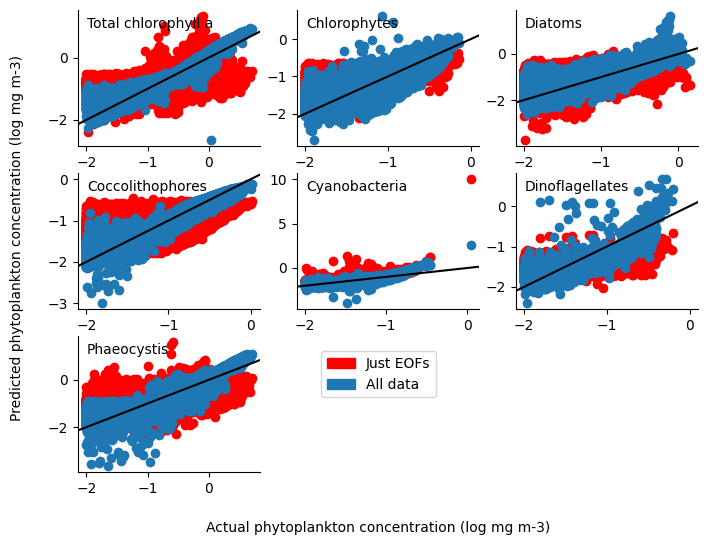

In [369]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(8,6)) #sharex=True, sharey=True,

axs = axs.ravel()

axs[0].scatter(rrs_xds_phyto_unstacked.log_tot, rrs_xds_phyto_unstacked.pred_log_tot_no_env, color='red')
axs[0].scatter(rrs_xds_phyto_unstacked.log_tot, rrs_xds_phyto_unstacked.pred_log_tot_all)
axs[0].axline((0, 0), slope=1, color='black')
axs[0].spines[['right', 'top']].set_visible(False)
axs[0].text(.05, .95, 'Total chlorophyll a', ha='left', va='top', transform=axs[0].transAxes)

axs[1].scatter(rrs_xds_phyto_unstacked.log_chl, rrs_xds_phyto_unstacked.pred_log_chl_no_env, color='red')
axs[1].scatter(rrs_xds_phyto_unstacked.log_chl, rrs_xds_phyto_unstacked.pred_log_chl_all)
axs[1].axline((0, 0), slope=1, color='black')
axs[1].spines[['right', 'top']].set_visible(False)
axs[1].text(.05, .95, 'Chlorophytes', ha='left', va='top', transform=axs[1].transAxes)

axs[2].scatter(rrs_xds_phyto_unstacked.log_dia, rrs_xds_phyto_unstacked.pred_log_dia_no_env, color='red')
axs[2].scatter(rrs_xds_phyto_unstacked.log_dia, rrs_xds_phyto_unstacked.pred_log_dia_all)
axs[2].axline((0, 0), slope=1, color='black')
axs[2].spines[['right', 'top']].set_visible(False)
axs[2].text(.05, .95, 'Diatoms', ha='left', va='top', transform=axs[2].transAxes)

axs[3].scatter(rrs_xds_phyto_unstacked.log_coc, rrs_xds_phyto_unstacked.pred_log_coc_no_env, color='red')
axs[3].scatter(rrs_xds_phyto_unstacked.log_coc, rrs_xds_phyto_unstacked.pred_log_coc_all)
axs[3].axline((0, 0), slope=1, color='black')
axs[3].spines[['right', 'top']].set_visible(False)
axs[3].text(.05, .95, 'Coccolithophores', ha='left', va='top', transform=axs[3].transAxes)

axs[4].scatter(rrs_xds_phyto_unstacked.log_cya, rrs_xds_phyto_unstacked.pred_log_cya_no_env, color='red')
axs[4].scatter(rrs_xds_phyto_unstacked.log_cya, rrs_xds_phyto_unstacked.pred_log_cya_all)
axs[4].axline((0, 0), slope=1, color='black')
axs[4].spines[['right', 'top']].set_visible(False)
axs[4].text(.05, .95, 'Cyanobacteria', ha='left', va='top', transform=axs[4].transAxes)

axs[5].scatter(rrs_xds_phyto_unstacked.log_din, rrs_xds_phyto_unstacked.pred_log_din_no_env, color='red')
axs[5].scatter(rrs_xds_phyto_unstacked.log_din, rrs_xds_phyto_unstacked.pred_log_din_all)
axs[5].axline((0, 0), slope=1, color='black')
axs[5].spines[['right', 'top']].set_visible(False)
axs[5].text(.05, .95, 'Dinoflagellates', ha='left', va='top', transform=axs[5].transAxes)

axs[6].scatter(rrs_xds_phyto_stacked.log_pha, rrs_xds_phyto_stacked.pred_log_pha_no_env, color='red')
axs[6].scatter(rrs_xds_phyto_stacked.log_pha, rrs_xds_phyto_stacked.pred_log_pha_all)
axs[6].axline((0, 0), slope=1, color='black')
axs[6].spines[['right', 'top']].set_visible(False)
axs[6].text(.05, .95, 'Phaeocystis', ha='left', va='top', transform=axs[6].transAxes)

fig.text(0.5, 0.01, 'Actual phytoplankton concentration (log mg m-3)', ha='center')
fig.text(0.04, 0.5, 'Predicted phytoplankton concentration (log mg m-3)', va='center', rotation='vertical')

fig.delaxes(axs[7])
fig.delaxes(axs[8])

red_patch = mpatches.Patch(color='red', label='Just EOFs')
blue_patch = mpatches.Patch(color='tab:blue', label='All data')
plt.legend(handles=[red_patch, blue_patch], loc='lower right', bbox_to_anchor=(2, 0.5))


### Not logged

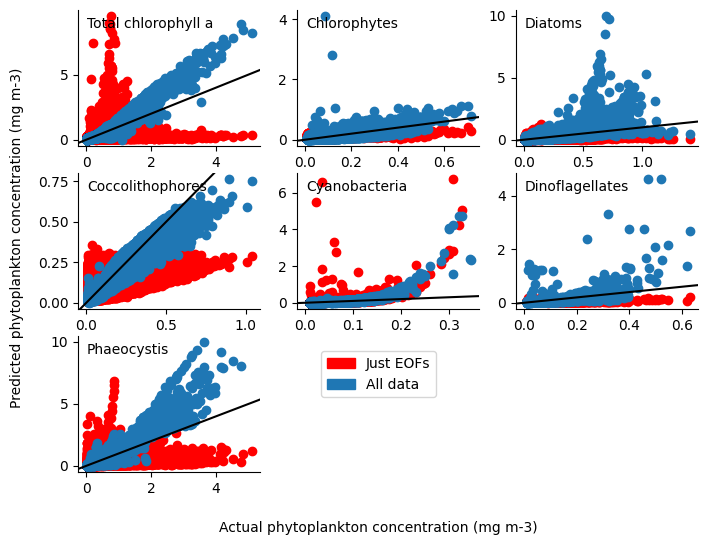

In [370]:
fig, axs = plt.subplots(nrows=3, ncols=3,  figsize=(8,6)) #sharex=True, sharey=True,

axs = axs.ravel()

axs[0].scatter(rrs_xds_phyto_unstacked.tot, rrs_xds_phyto_unstacked.pred_tot_no_env, color='red')
axs[0].scatter(rrs_xds_phyto_unstacked.tot, rrs_xds_phyto_unstacked.pred_tot_all)
axs[0].axline((0, 0), slope=1, color='black')
axs[0].spines[['right', 'top']].set_visible(False)
axs[0].text(.05, .95, 'Total chlorophyll a', ha='left', va='top', transform=axs[0].transAxes)

axs[1].scatter(rrs_xds_phyto_unstacked.chl, rrs_xds_phyto_unstacked.pred_chl_no_env, color='red')
axs[1].scatter(rrs_xds_phyto_unstacked.chl, rrs_xds_phyto_unstacked.pred_chl_all)
axs[1].axline((0, 0), slope=1, color='black')
axs[1].spines[['right', 'top']].set_visible(False)
axs[1].text(.05, .95, 'Chlorophytes', ha='left', va='top', transform=axs[1].transAxes)

axs[2].scatter(rrs_xds_phyto_unstacked.dia, rrs_xds_phyto_unstacked.pred_dia_no_env, color='red')
axs[2].scatter(rrs_xds_phyto_unstacked.dia, rrs_xds_phyto_unstacked.pred_dia_all)
axs[2].axline((0, 0), slope=1, color='black')
axs[2].spines[['right', 'top']].set_visible(False)
axs[2].text(.05, .95, 'Diatoms', ha='left', va='top', transform=axs[2].transAxes)

axs[3].scatter(rrs_xds_phyto_unstacked.coc, rrs_xds_phyto_unstacked.pred_coc_no_env, color='red')
axs[3].scatter(rrs_xds_phyto_unstacked.coc, rrs_xds_phyto_unstacked.pred_coc_all)
axs[3].axline((0, 0), slope=1, color='black')
axs[3].spines[['right', 'top']].set_visible(False)
axs[3].text(.05, .95, 'Coccolithophores', ha='left', va='top', transform=axs[3].transAxes)

axs[4].scatter(rrs_xds_phyto_unstacked.cya, rrs_xds_phyto_unstacked.pred_cya_no_env, color='red')
axs[4].scatter(rrs_xds_phyto_unstacked.cya, rrs_xds_phyto_unstacked.pred_cya_all)
axs[4].axline((0, 0), slope=1, color='black')
axs[4].spines[['right', 'top']].set_visible(False)
axs[4].text(.05, .95, 'Cyanobacteria', ha='left', va='top', transform=axs[4].transAxes)

axs[5].scatter(rrs_xds_phyto_unstacked.din, rrs_xds_phyto_unstacked.pred_din_no_env, color='red')
axs[5].scatter(rrs_xds_phyto_unstacked.din, rrs_xds_phyto_unstacked.pred_din_all)
axs[5].axline((0, 0), slope=1, color='black')
axs[5].spines[['right', 'top']].set_visible(False)
axs[5].text(.05, .95, 'Dinoflagellates', ha='left', va='top', transform=axs[5].transAxes)

axs[6].scatter(rrs_xds_phyto_unstacked.pha, rrs_xds_phyto_unstacked.pred_pha_no_env, color='red')
axs[6].scatter(rrs_xds_phyto_unstacked.pha, rrs_xds_phyto_unstacked.pred_pha_all)
axs[6].axline((0, 0), slope=1, color='black')
axs[6].spines[['right', 'top']].set_visible(False)
axs[6].text(.05, .95, 'Phaeocystis', ha='left', va='top', transform=axs[6].transAxes)

fig.text(0.5, 0.01, 'Actual phytoplankton concentration (mg m-3)', ha='center')
fig.text(0.04, 0.5, 'Predicted phytoplankton concentration (mg m-3)', va='center', rotation='vertical')

fig.delaxes(axs[7])
fig.delaxes(axs[8])

red_patch = mpatches.Patch(color='red', label='Just EOFs')
blue_patch = mpatches.Patch(color='tab:blue', label='All data')
plt.legend(handles=[red_patch, blue_patch], loc='lower right', bbox_to_anchor=(2, 0.5))



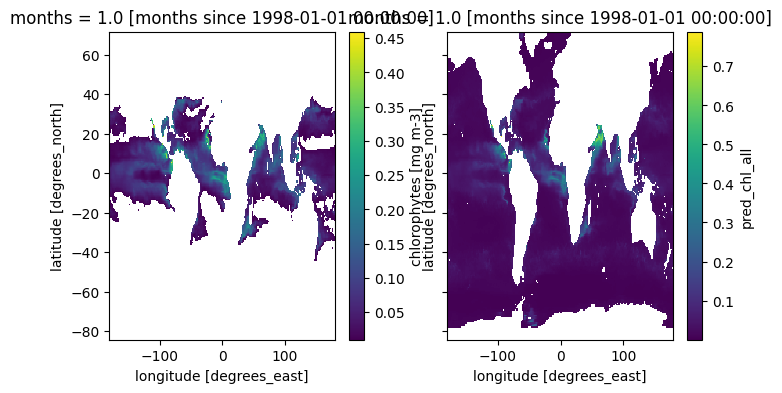

In [353]:
fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(8,4))

axs = axs.ravel()

rrs_xds_phyto_unstacked.chl[:,:,1].plot(ax=axs[0])
rrs_xds_phyto_unstacked.pred_chl_all[:,:,1].plot(ax=axs[1])

TODO:
- show scatterplots with and without including env variables 

- rememeber for discussion- how these models w/ env variables can best predict phyto in a changing climate 